In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import clear_output
import seaborn as sns

import cPickle as pk
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import itertools as itls
from itertools import combinations
import numpy as np
from math import sqrt

import sys

## Importing
[to top](#Table-of-Contents) 

In [2]:
pwd

u'/Users/youn/Dropbox/WORK/technologycode/datasets/epo/data_processing/python'

In [3]:
df = pk.load(open('pickles_and_munged_csv/pre1950_cated_cumed_codes_as_ints_v1.pk', 'rb')); df.head()

appln_auth,AT,AU,BE,CA,CH,DE,DK,ES,FI,FR,...,IE,IS,IT,JP,LU,NL,NO,SE,SU,US
pub_year,,,,,,,,,,,,,,,,,,,,,
1836,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1513, 1789], [1268, 1855], [1762, 1821], [24..."
1837,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[5834, 5836], [4907, 5440], [799, 5648], [602..."
1838,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1537, 1774], [1154, 1208], [2724, 2748], [40..."
1839,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[4212, 4231], [5078, 6180], [4915, 5001], [33..."
1840,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[2722, 2748], [1862, 1862], [1161, 5985], [48..."


In [4]:
s_US = df.US

In [5]:
del df

In [6]:
s_US

pub_year
1836    [[1513, 1789], [1268, 1855], [1762, 1821], [24...
1837    [[5834, 5836], [4907, 5440], [799, 5648], [602...
1838    [[1537, 1774], [1154, 1208], [2724, 2748], [40...
1839    [[4212, 4231], [5078, 6180], [4915, 5001], [33...
1840    [[2722, 2748], [1862, 1862], [1161, 5985], [48...
1841    [[5986, 6001], [3027, 5586], [2964, 3002], [18...
1842    [[4897, 5004], [5740, 5803], [5349, 5421], [11...
1843    [[1762, 1821], [1762, 1821], [5704, 5807], [57...
1844    [[3764, 3825], [1520, 1764], [4641, 4643], [11...
1845    [[5318, 5404], [1060, 4759], [3969, 4052], [23...
1846    [[4097, 6441], [5610, 6516], [1204, 1758], [17...
1847    [[4097, 6441], [1816, 1817], [1722, 5438], [17...
1848    [[335, 2889], [4315, 4750], [5471, 5479, 5479]...
1849    [[5479, 5479], [1496, 1622], [1237, 5473], [50...
1850    [[1754, 1764], [659, 813], [1513, 1789], [1848...
1851    [[327, 332], [4810, 5731], [1829, 1853], [5740...
1852    [[5687, 6199], [4898, 4929], [110, 1211], [489...
1853 

# AdjM building

In [7]:
def make_match_node_intersection_AdjDfs(df1, df2):
    
    # assumes dfs are symmetric and square
    # should implement a check here...
    
    # get union of dataframe indexes
    inx_1 = df1.index
    inx_2 = df2.index
    inx_un = inx_1.intersection(inx_2)
    
    # reindex both index and columns for just 
    df1 = df1.reindex(index=inx_un).reindex(columns=inx_un)
    df2 = df2.reindex(index=inx_un).reindex(columns=inx_un)
    
    return df1, df2

# DeltaCon

In [8]:
def compute_FBP_invs(A):

    # max power to calculate inverse to
    max_pw = 7

    # make identity
    I = sp.identity(A.shape[0])
 
    # remove self links - can't propogate beliefs to self - need to consider if the self links should be counted in
    # degree still?
    A = A - sp.dia_matrix((A.diagonal(), [0]),
                                    shape=(A.shape[0], A.shape[0]))

    # make degree matrix
    ds = [int(x) for x in A.sum(axis=1)]
    D = sp.dia_matrix((ds, [0]),
                     shape=(len(ds), len(ds)))
    
    # compute about-half homophility factor that gaurentees convergences of W power series
    c1 = D.sum() + 2
    c2 = np.dot(D,D).sum() - 1 
    h_h = sqrt((-c1+sqrt(c1**2 + 4*c2))
               /(8*c2)
              )
    
    # compute system constants ah (from ahD) and ch from (achA)
    ah = 4*(h_h**2) /(1-4*(h_h**2))
    ch = 2*h_h / (1-4*(h_h**2))
    
    # create matrix M to form (I - M)^-1
    M = ch*A - ah*D
    
    # expand to power series to compute inverse
    inv = I
    mat = M
    pwr = 1
    while mat.data[mat.data.argmax()] > 10**(-9) and pwr < max_pw:
        inv = inv + mat
        mat = mat * M
        pwr = pwr + 1
    return inv

In [9]:
def DeltaCon(A1, A2):
    
    # quick return for identical networks
    if (A1 != A2).nnz == 0:
        print 'Iden'
        return 1.0
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon says paper)
    # BUT it massively effects the results!!!!!!!
    # the closer to 0.5, the greater the dampening on differences
    p = 0.51
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    diffM = (inv1.sqrt() - inv2.sqrt())
    diffM = diffM.multiply(diffM)
    
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = diffM - sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))

    return 1 / (1 + sqrt(diffM.sum()))

# Applying

In [10]:
def compute_DeltaCon_US_sims(s_US, years):
    
    # create dataframe to store similarities
    df_temp = pd.DataFrame()
    
    # for countries in dataset
    for i, y1 in enumerate(years):
        print '\n%s' % y1 # to see progress
    
            
        # create adjacency dataframe df1 (via nx.graph) for country1
        g1 = nx.MultiGraph()
        for ls in s_US.loc[y1]:
            g1.add_edges_from(combinations(ls, 2))
        Adf1 = nx.to_pandas_dataframe(g1)

        # for countries 'greater' than country1 in dataset 
        for y2 in years[i:]:
            print y2

            # if countries are the same then set similarity to 1
            if y1 == y2:
                print 'self',
                df_temp.loc[y1,y2] = 1

            # else if the country of not empty then calculate DeltaCon sim for country1 and country2
            else:
                print y2, # to see progress

                # create adjacency dataframe df2 (via nx.graph) for country2
                g2 = nx.MultiGraph()
                for ls in s_US.loc[y2]:
                    g2.add_edges_from(combinations(ls, 2))    
                Adf2 = nx.to_pandas_dataframe(g2)

                # make adjacency dataframes compatible
                Adf1, Adf2 = make_match_node_intersection_AdjDfs(Adf1, Adf2)

                # convert to csr and compute DeltaCon
                sim = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))
                print sim

                #assign to dataframe
                df_temp.loc[y1,y2] = sim
                df_temp.loc[y2,y1] = sim
                    
    return df_temp

In [11]:
# initialise 
years = range(1900,2020,10)
USdf = compute_DeltaCon_US_sims(s_US, years)


1900
1900
self 1910
1910 0.51927490461
1920
1920 0.316864341176
1930
1930 0.279059348937
1940
1940 0.217813529903
1950
1950 0.186267705346
1960
1960 0.122143763262
1970
1970 0.0846421096431
1980
1980 0.0284650854324
1990
1990 0.00780884659123
2000
2000 0.000120521328665
2010
2010 5.26772993648e-05

1910
1910
self 1920
1920 0.407308945451
1930
1930 0.314376208243
1940
1940 0.230317551775
1950
1950 0.193005106615
1960
1960 0.124505526189
1970
1970 0.07158494345
1980
1980 0.0157653416392
1990
1990 0.00348144649356
2000
2000 0.000125988835814
2010
2010 5.07806909419e-05

1920
1920
self 1930
1930 0.369589408635
1940
1940 0.246102893739
1950
1950 0.168439366477
1960
1960 0.0881044816313
1970
1970 0.0623518755462
1980
1980 0.0172741318561
1990
1990 0.00399930733737
2000
2000 0.000139529011799
2010
2010 5.82782804157e-05

1930
1930
self 1940
1940 0.356873142701
1950
1950 0.199014184879
1960
1960 0.0931592159452
1970
1970 0.0652784103164
1980
1980 0.0172483786678
1990
1990 0.00413409897057
200

In [12]:
USdf

,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
1900,1.000000,0.519275,0.316864,0.279059,0.217814,0.186268,0.122144,0.084642,0.028465,0.007809,0.000121,0.000053
1910,0.519275,1.000000,0.407309,0.314376,0.230318,0.193005,0.124506,0.071585,0.015765,0.003481,0.000126,0.000051
1920,0.316864,0.407309,1.000000,0.369589,0.246103,0.168439,0.088104,0.062352,0.017274,0.003999,0.000140,0.000058
1930,0.279059,0.314376,0.369589,1.000000,0.356873,0.199014,0.093159,0.065278,0.017248,0.004134,0.000105,0.000052
1940,0.217814,0.230318,0.246103,0.356873,1.000000,0.245739,0.101079,0.068502,0.016813,0.004163,0.000111,0.000056
1950,0.186268,0.193005,0.168439,0.199014,0.245739,1.000000,0.132651,0.078654,0.017262,0.004270,0.000112,0.000057
1960,0.122144,0.124506,0.088104,0.093159,0.101079,0.132651,1.000000,0.118574,0.018203,0.004361,0.000110,0.000055
1970,0.084642,0.071585,0.062352,0.065278,0.068502,0.078654,0.118574,1.000000,0.020284,0.004406,0.000100,0.000051
1980,0.028465,0.015765,0.017274,0.017248,0.016813,0.017262,0.018203,0.020284,1.000000,0.005236,0.000083,0.000041
1990,0.007809,0.003481,0.003999,0.004134,0.004163,0.004270,0.004361,0.004406,0.005236,1.000000,0.000083,0.000041


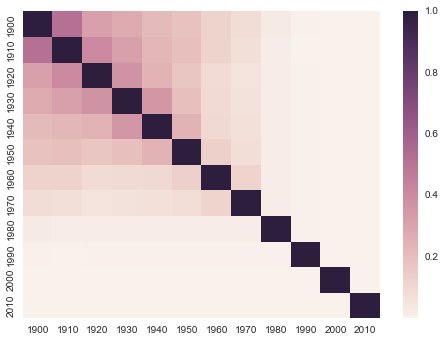

In [15]:
sns.heatmap(USdf)

In [14]:
USdf

,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
1900,1.000000,0.519275,0.316864,0.279059,0.217814,0.186268,0.122144,0.084642,0.028465,0.007809,0.000121,0.000053
1910,0.519275,1.000000,0.407309,0.314376,0.230318,0.193005,0.124506,0.071585,0.015765,0.003481,0.000126,0.000051
1920,0.316864,0.407309,1.000000,0.369589,0.246103,0.168439,0.088104,0.062352,0.017274,0.003999,0.000140,0.000058
1930,0.279059,0.314376,0.369589,1.000000,0.356873,0.199014,0.093159,0.065278,0.017248,0.004134,0.000105,0.000052
1940,0.217814,0.230318,0.246103,0.356873,1.000000,0.245739,0.101079,0.068502,0.016813,0.004163,0.000111,0.000056
1950,0.186268,0.193005,0.168439,0.199014,0.245739,1.000000,0.132651,0.078654,0.017262,0.004270,0.000112,0.000057
1960,0.122144,0.124506,0.088104,0.093159,0.101079,0.132651,1.000000,0.118574,0.018203,0.004361,0.000110,0.000055
1970,0.084642,0.071585,0.062352,0.065278,0.068502,0.078654,0.118574,1.000000,0.020284,0.004406,0.000100,0.000051
1980,0.028465,0.015765,0.017274,0.017248,0.016813,0.017262,0.018203,0.020284,1.000000,0.005236,0.000083,0.000041
1990,0.007809,0.003481,0.003999,0.004134,0.004163,0.004270,0.004361,0.004406,0.005236,1.000000,0.000083,0.000041


In [17]:
pk.dump(USdf, open('pickles_and_munged_csv/sim_dfs/all_grant_no_priors_pre1950_deltacon_intersect_sim_US_1900_2010.pk', 'wb'))